In [83]:
from datasets import load_dataset, get_dataset_config_names
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Downloading

In [166]:
config = get_dataset_config_names('Helsinki-NLP/opus-100')
data = load_dataset('Helsinki-NLP/opus-100', 'bn-en')
data['train'].to_csv("./data/train_data.csv")

Creating CSV from Arrow format: 100%|██████████| 1000/1000 [00:05<00:00, 187.98ba/s]


265553291

## Data 

In [167]:
df = pd.read_csv('/home/arafat/projects/deeplearning_crash_course/data/train_data.csv')
df['translation_dict'] = df['translation'].apply(eval)


df['bn'] = df['translation_dict'].apply(lambda x: x['bn'])
df['en'] = df['translation_dict'].apply(lambda x: x['en'])


df = df.drop('translation_dict', axis=1)
df.to_csv("./data/bangla_english_translation.csv")

In [163]:
df.loc[100:150, ['bn', 'en']].values[:, 0]

array(['চিহ্নিত অনুসন্ধানের ফোল্ডারের নাম উল্লেখ করা আবশ্যক',
       'কাফেররা যেন মনে না করে যে আমি যে , অবকাশ দান করি , তা তাদের পক ্ ষে কল ্ যাণকর । আমি তো তাদেরকে অবকাশ দেই যাতে করে তারা পাপে উন ্ নতি লাভ করতে পারে । বস ্ তুতঃ তাদের জন ্ য রয়েছে লাঞ ্ ছনাজনক শাস ্ তি ।',
       'সেদিন তাদের চক ্ রান ্ ত তাদের কোন উপকারে আসবে না এবং তারা সাহায ্ যপ ্ রাপ ্ তও হবে না ।',
       'একটা দুঃসংবাদ দিবো।',
       "আর ইহুদী ও খ ্ রীষ ্ টানরা বলে -- ''আমরা আল্লাহ্\u200cর সন্তান ও তাঁর প্রিয়পাত্র।’’ তুমি বলো -- ''তবে কেন তোমাদের অপরাধের জন্য তিনি তোমাদের শাস্তি দেন? না, যাদের তিনি সৃষ্টি করেছেন তোমরা তাদের মধ্যেকার মানুষ। তিনি যাকে ইচ্ছে করেন পরিত্রাণ করেন এবং যাকে ইচ্ছে করেন শাস্তি দেন।’’ আর আল্লাহ্\u200cরই মহাকাশমন্ডল ও পৃথিবীর সাম্রাজ্য এবং এই দুইয়ের মধ্যে যা আছে, আর তাঁরই দিকে প্রত্যাবর্তন।",
       'এটা দেখ তো।',
       'এই রসূলগণ-আমি তাদের কাউকে কারো উপর মর ্ যাদা দিয়েছি । তাদের মধ ্ যে কেউ তো হলো তারা যার সাথে আল ্ লাহ কথা বলেছেন , আর কারও মর ্ যাদা উচ ্ চতর করেছেন এবং আমি মরিয়

## Train a Tokenizer

In [42]:
import os
from typing import Literal

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [2]:
def train_and_save_tokenizer(file_path:str, output_path:str, vocab_size:int, lang:str = Literal['bn', 'en']):
    if not os.path.exists(file_path):
        raise FileNotFoundError("File Path Does Not Exist")
    
    df = pd.read_csv(file_path)
    df = df.dropna()
    training_data = df.loc[:, lang].values
    
    tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(vocab_size=vocab_size,
                               min_frequency=2,
                               special_tokens=["[UNK]", "[PAD]", "[EOS]", "[SOS]"])
    
    tokenizer.train_from_iterator(training_data, trainer)
    
    os.makedirs(output_path, exist_ok=True)
    tokenizer.save(f"./{output_path}/{lang}_tokenizer.json")
    return tokenizer

In [5]:
path = '/home/arafat/projects/deeplearning_crash_course/data/bangla_english_translation.csv'
en_tokenizer = train_and_save_tokenizer(path, 'Tokenizer', 1000, 'en')
bn_tokenizer = train_and_save_tokenizer(path, 'Tokenizer', 1000, 'bn')

In [14]:
tokenizer = Tokenizer.from_file('/home/arafat/projects/deeplearning_crash_course/Tokenizer/en_tokenizer.json')
tokenizer.enable_padding(
    pad_id=tokenizer.token_to_id("[PAD]"),
    pad_token="[PAD]",
    length=None,
    # length=50,
    direction='right'
)

sample_text = "This is a test sentence"
encoding = tokenizer.encode(sample_text)
encoding.ids, encoding.tokens

# token = torch.stack([encoding[0].ids, encoding[1].ids], padding=True)

([89, 14, 11, 0, 0], ['This', 'is', 'a', '[UNK]', '[UNK]'])

## DataLoader

In [68]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [193]:
def collate_function(batch):
    bn_sentences = [item[0] for item in batch]
    en_sentences = [item[1] for item in batch]
    bn_padded = torch.nn.utils.rnn.pad_sequence(bn_sentences, batch_first=True, padding_value=1)
    en_padded = torch.nn.utils.rnn.pad_sequence(en_sentences, batch_first=True, padding_value=1)
    return bn_padded, en_padded

In [ ]:
class MachineTranslation(Dataset):
    def __init__(self, file_path:str, en_tokenizer_path:str, bn_tokenizer_path:str, split:str='train'):
        super().__init__()

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File Path does not exists for {file_path}")
        if not os.path.exists(en_tokenizer_path):
            raise FileNotFoundError(f"File Path does not exists for {en_tokenizer_path}")
        if not os.path.exists(bn_tokenizer_path):
            raise FileNotFoundError(f"File Path does not exists for {bn_tokenizer_path}")
        assert split in ["train", "validation"], "Split must be either 'train' or 'validation'"
                
        self.file_path = file_path
        self.csv_file = pd.read_csv(file_path)
        if split == "train":
            self.csv_file = self.csv_file.sample(frac=0.8, random_state=42)
            
        self.en_tokenizer = Tokenizer.from_file(en_tokenizer_path)
        self.bn_tokenizer = Tokenizer.from_file(bn_tokenizer_path)
        
        self.en_tokenizer.enable_padding(
            pad_id=self.en_tokenizer.token_to_id("[PAD]"),
            pad_token="[PAD]",
            length=None,
            direction='right'
        )
        
        self.bn_tokenizer.enable_padding(
            pad_id=self.bn_tokenizer.token_to_id("[PAD]"),
            pad_token="[PAD]",
            length=None,
            direction='right'
        )
        
        
    def __getitem__(self, idx):
        sentences = self.csv_file.loc[idx, ['bn', 'en']].values
        bangla, english = sentences[0], sentences[1]
        bn_encoding = self.bn_tokenizer.encode(bangla)
        en_encoding = self.en_tokenizer.encode(english)
        return torch.tensor(bn_encoding.ids), torch.tensor(en_encoding.ids)
        
    
    def __len__(self):
        return len(self.csv_file)

In [195]:
dataset = MachineTranslation(path, './Tokenizer/en_tokenizer.json', './Tokenizer/bn_tokenizer.json')
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=collate_function)

In [202]:
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([10, 57]), torch.Size([10, 67]))

In [212]:
token_id = x[9].tolist()
bn_tokenizer.decode(token_id)


'ছবি জন্য তৈরি করা'

In [215]:
df = pd.read_csv('/home/arafat/projects/deeplearning_crash_course/data/bangla_english_translation.csv')

bn    হ্যাঁ?
en     Yeah?
Name: 0, dtype: object

In [217]:
df.loc[100:120, ['bn', 'en']]

,bn,en
100,চিহ্নিত অনুসন্ধানের ফোল্ডারের নাম উল্লেখ করা আ...,You must name this Search Folder.
101,"কাফেররা যেন মনে না করে যে আমি যে , অবকাশ দান ক...",Those who disbelieve should not assume that We...
102,সেদিন তাদের চক ্ রান ্ ত তাদের কোন উপকারে আসব...,A day on which their scheming will not benefit...
103,একটা দুঃসংবাদ দিবো।,I've got some bad news.
104,আর ইহুদী ও খ ্ রীষ ্ টানরা বলে -- ''আমরা আল্লা...,"No : You are only mortals , of His creation . ..."
105,এটা দেখ তো।,Check that out.
106,এই রসূলগণ-আমি তাদের কাউকে কারো উপর মর ্ যাদা ...,"And to Jesus , son of Mary , We gave tokens , ..."
107,"দুর ্ বলরা অহংকারীদেরকে বলবে , বরং তোমরাই তো...",Those who were despised say unto those who wer...
108,রুহিতনের বিবি,the queen of diamonds
109,"এখন বাইরে চলো, চলো, যাই","Come on, let's go."


In [ ]:
x = torch.tensor(1).unsqueeze(0)
y = torch.tensor([2,3,4,5])
torch.cat([y, x])

TypeError: expected Tensor as element 1 in argument 0, but got list

In [1]:
import torch

In [6]:
mask = torch.zeros(10, 10)
mask[:x.shape[0], :x.shape[1]] = 1
mask

tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
x = torch.rand(5,5)


tensor([[0.7036, 0.4407, 0.7141, 0.2086, 0.4266],
        [0.8826, 0.2820, 0.4906, 0.6313, 0.6343],
        [0.2236, 0.9251, 0.9680, 0.4137, 0.7161],
        [0.2739, 0.2671, 0.5580, 0.2215, 0.4544],
        [0.6278, 0.4673, 0.2455, 0.0232, 0.7803]])

In [8]:
import pandas as pd
data = pd.read_csv('D:/notebook/deeplearning_crash_course/data/bangla_english_translation.csv')

In [ ]:
sample = data.sample(frac=0.3)
other = data[data.index != sample.index]


## Testing Dataset

In [145]:
import os
import sys
sys.path.append('/home/arafat/projects/deeplearning_crash_course')

In [146]:
from dataset import get_dataloder

In [154]:
from torch.utils.data import Dataset, DataLoader
import torch
from tokenizers import Tokenizer #type:ignore
from typing import Literal
import pandas as pd #type:ignore

from train_tokenizer import load_tokenizer


def causal_mask(size):
    mask = torch.tril(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return mask  


def get_dataloder(config):
    data = pd.read_csv(config.data_path)
    data = data[(data['bn_token_len'] < 50) & (data['en_token_len'] < 50)]
    val_data = data.sample(frac=config.test_size)
    train_data = data.drop(val_data.index)
    val_data.reset_index(inplace=True)
    train_data.reset_index(inplace=True)

    src_tokenizer = load_tokenizer(config.src_lang)
    tgt_tokenizer = load_tokenizer(config.tgt_lang)
    train_dataset = LanguageTranslation(train_data, src_tokenizer, tgt_tokenizer, config.src_lang, config.tgt_lang, config.seq_len)
    val_dataset = LanguageTranslation(val_data, src_tokenizer, tgt_tokenizer, config.src_lang, config.tgt_lang, config.seq_len)

    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)
    return train_dataloader, val_dataloader


class LanguageTranslation(Dataset):
    def __init__(self, ds:pd.DataFrame, src_tokenizer:Tokenizer, tgt_tokenizer:Tokenizer, src_lang:str, tgt_lang:str, seq_len:int):
        
        self.ds = ds
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.seq_len = seq_len
        
        self.sos_token = torch.tensor(self.src_tokenizer.token_to_id("[SOS]"), dtype=torch.int64).unsqueeze(0)
        self.eos_token = torch.tensor(self.src_tokenizer.token_to_id("[EOS]"), dtype=torch.int64).unsqueeze(0)
        self.pad_token = [self.src_tokenizer.token_to_id("[PAD]")]
        
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        print(f"Index : {index}")
        src_text = self.ds.loc[index, self.src_lang]
        tgt_text = self.ds.loc[index, self.tgt_lang]
        src_encoding = self.src_tokenizer.encode(src_text)
        tgt_encoding = self.tgt_tokenizer.encode(tgt_text)
        
        src_pad_len = self.seq_len - len(src_encoding.ids) - 2
        tgt_pad_len = self.seq_len - len(tgt_encoding.ids) - 1
        
        if src_pad_len < 0 or tgt_pad_len < 0:
            raise ValueError("Seq Length cannot be Less Token Length")
        
        encoder_input = torch.cat([
            self.sos_token, 
            torch.tensor(src_encoding.ids, dtype=torch.int64), 
            self.eos_token, 
            torch.tensor(src_pad_len*self.pad_token, dtype=torch.int64)
        ])
        
        decoder_input = torch.cat([
            self.sos_token,
            torch.tensor(tgt_encoding.ids, dtype=torch.int64),
            torch.tensor(self.pad_token*tgt_pad_len, dtype=torch.int64)
        ])
        
        label = torch.cat([
            torch.tensor(tgt_encoding.ids, dtype=torch.int64),
            self.eos_token,
            torch.tensor(self.pad_token*tgt_pad_len, dtype=torch.int64)
        ])

        encoder_mask = (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int()
        decoder_mask = (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0))

        return {
            'encoder_input':encoder_input,
            'decoder_input':decoder_input,
            'encoder_mask':encoder_mask,
            'decoder_mask':decoder_mask,
            'label':label,
            'src_text':src_text,
            'tgt_text':tgt_text
        }



In [147]:
class config:
    data_path = './data/bangla_english_translation.csv'
    test_size = 0.2
    batch_size = 10
    epcohs = 10
    lr = 1e-4
    src_lang = 'en'
    tgt_lang = 'bn'
    src_vocab_size = 1000
    tgt_vocab_size = 1000
    seq_len = 50
    d_model = 512
    N = 6
    h = 8

In [155]:
train_dataloader, val_dataloader = get_dataloder(config)

In [156]:
data = next(iter(train_dataloader))

Index : 729692


AttributeError: 'bool' object has no attribute 'unsqueeze'

In [ ]:
import pandas as pd
data = pd.read_csv("./data/bangla_english_translation.csv")
# sample = data.sample(frac=0.2)

In [45]:
bn_tokenizer = Tokenizer.from_file('/home/arafat/projects/deeplearning_crash_course/Tokenizer/bn_tokenizer.json')
en_tokenizer = Tokenizer.from_file('/home/arafat/projects/deeplearning_crash_course/Tokenizer/en_tokenizer.json')

In [67]:
data['bn_token_len'] = data['bn'].apply(lambda x: len(bn_tokenizer.encode(str(x)).ids))
data['en_token_len'] = data['en'].apply(lambda x: len(en_tokenizer.encode(str(x)).ids))

In [76]:
data[(data['bn_token_len'] > 100) | (data['en_token_len'] > 100)]

,translation,bn,en,bn_token_len,en_token_len
88,{'bn': 'আপনি জিজ ্ ঞেস করুনঃ সর ্ ববৃহৎ সাক ্ ...,আপনি জিজ ্ ঞেস করুনঃ সর ্ ববৃহৎ সাক ্ ষ ্ যদাত...,This Koran has been revealed to me in order th...,119,59
106,{'bn': 'এই রসূলগণ-আমি তাদের কাউকে কারো উপর মর...,এই রসূলগণ-আমি তাদের কাউকে কারো উপর মর ্ যাদা ...,"And to Jesus , son of Mary , We gave tokens , ...",165,41
231,"{'bn': 'হজ হয় কয়েকটি সুবিখ ্ যাত মাসে , কাজেই ...","হজ হয় কয়েকটি সুবিখ ্ যাত মাসে , কাজেই যে কেউ এ...",Whoever decides to perform the Hajj — there sh...,111,33
250,{'bn': 'আর আল ্ লাহ ্ \u200c র জন ্ য সম ্ পূর...,আর আল ্ লাহ ্ ‌ র জন ্ য সম ্ পূর ্ ণ করো হজ ...,But if ye are prevented ( From completing it )...,201,142
277,"{'bn': 'তিনি আকাশ থেকে পানি অবতারণ করেন , তারপ...","তিনি আকাশ থেকে পানি অবতারণ করেন , তারপর জলধারা...",He sends down water from the sky and the valle...,109,60
...,...,...,...,...,...
999244,{'bn': 'তোমাদের মধ ্ যে যারা ঈমান এনেছে এবং স...,তোমাদের মধ ্ যে যারা ঈমান এনেছে এবং সৎকর ্ ম ...,God has promised to make those of you who beli...,138,58
999275,{'bn': 'নির ্ দিষ ্ টসংখ ্ যক দিনের জন ্ য । ক...,নির ্ দিষ ্ টসংখ ্ যক দিনের জন ্ য । কিন ্ তু ...,"If , however , anyone of you be sick or on a j...",103,70
999636,"{'bn': 'হে , মুমিনগণ , তোমাদের মধ ্ যে যখন কা...","হে , মুমিনগণ , তোমাদের মধ ্ যে যখন কারও মৃত ্...","When death approaches one of you , let two rel...",130,51
999776,"{'bn': 'হে নবী , তোমরা যখন স ্ ত ্ রীদেরকে তা...","হে নবী , তোমরা যখন স ্ ত ্ রীদেরকে তালাক দিতে...","When ye ( men ) put away women , put them away...",128,50


Text(0.5, 1.0, 'English Token Length')

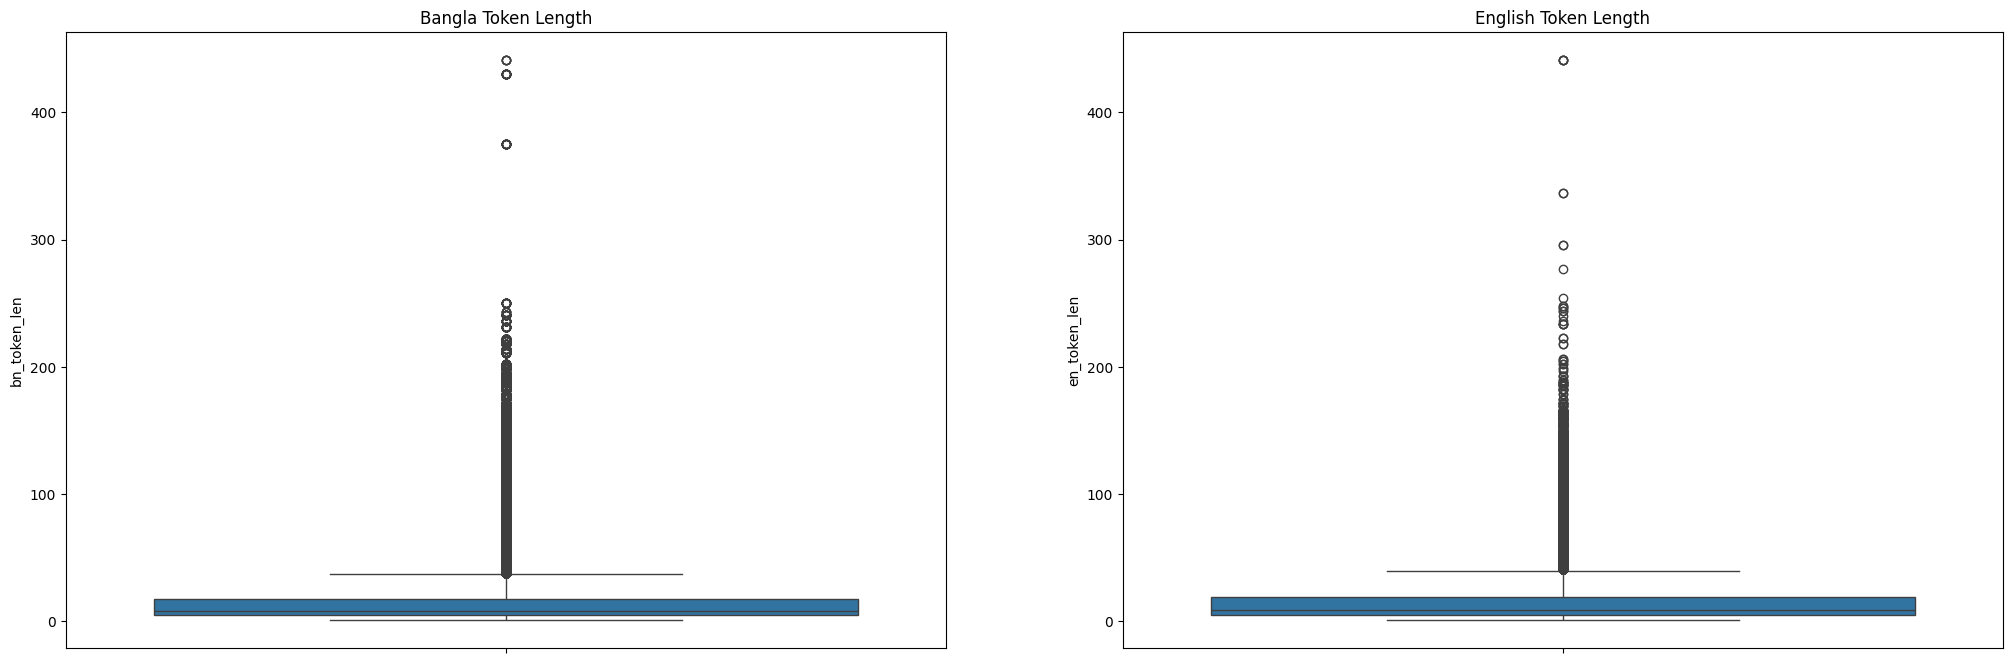

In [88]:
plt.figure(figsize=(25, 8))
plt.subplot(1,2,1)
sns.boxplot(y='bn_token_len', data=data)
plt.title("Bangla Token Length")

plt.subplot(1,2,2)
sns.boxplot(y="en_token_len", data=data)
plt.title("English Token Length")

Text(0.5, 1.0, 'English Token Length')

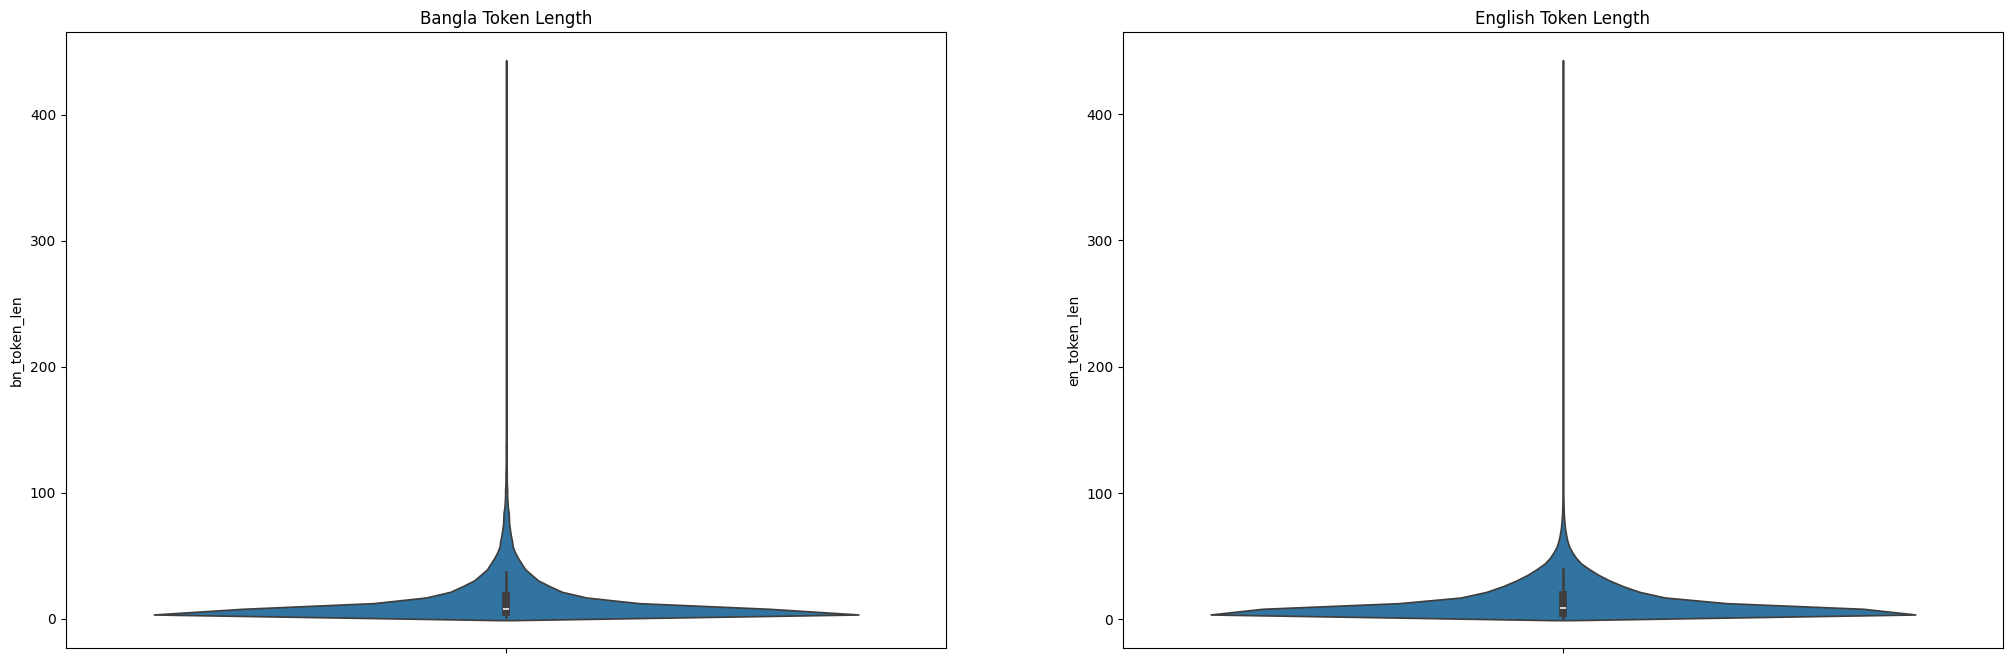

In [90]:
plt.figure(figsize=(25, 8))
plt.subplot(1,2,1)
sns.violinplot(y='bn_token_len', data=data)
plt.title("Bangla Token Length")

plt.subplot(1,2,2)
sns.violinplot(y="en_token_len", data=data)
plt.title("English Token Length")

In [97]:
print(data['bn_token_len'].describe())
print(data['en_token_len'].describe())

count    1000000.000000
mean          14.702252
std           17.615556
min            1.000000
25%            5.000000
50%            8.000000
75%           18.000000
max          441.000000
Name: bn_token_len, dtype: float64
count    1000000.000000
mean          14.254481
std           13.863311
min            1.000000
25%            5.000000
50%            9.000000
75%           19.000000
max          441.000000
Name: en_token_len, dtype: float64


In [102]:
data[(data['bn_token_len'] < 50) & (data['en_token_len'] < 50)]

,translation,bn,en,bn_token_len,en_token_len
0,"{'bn': 'হ্যাঁ?', 'en': 'Yeah?'}",হ্যাঁ?,Yeah?,2,2
1,{'bn': 'তিনি বললেনঃ অতঃপর তোমাদের প ্ রধান উদ...,তিনি বললেনঃ অতঃপর তোমাদের প ্ রধান উদ ্ দেশ ্...,"Messengers , what is your task ? """,21,8
2,{'bn': 'ই-মেইল অ্যাকাউন্টগুলিকে এখানে কনফিগার ...,ই-মেইল অ্যাকাউন্টগুলিকে এখানে কনফিগার করুন,Configure email accounts,7,3
3,{'bn': 'আমি যখন মানুষের প ্ রতি অনুগ ্ রহ করি ...,আমি যখন মানুষের প ্ রতি অনুগ ্ রহ করি তখন সে ম...,"When We bestow Our favour upon man , he turns ...",47,28
4,"{'bn': '- ঠিক আছে.', 'en': '- Okay.'}",- ঠিক আছে.,- Okay.,4,3
...,...,...,...,...,...
999995,"{'bn': 'ওহ্\u200c হ্যা.', 'en': 'Oh, yes.'}",ওহ্‌ হ্যা.,"Oh, yes.",3,4
999996,{'bn': 'অতঃপর ফেরাউন পরিবার মূসাকে কুড়িয়ে নিল ...,"অতঃপর ফেরাউন পরিবার মূসাকে কুড়িয়ে নিল , যাতে ত...",So then the folk of Pharaoh picked him out to ...,34,33
999997,"{'bn': 'এটা বুঝা যাচ্ছে যে, ভেতর থেকেই সব ষড়যন...","এটা বুঝা যাচ্ছে যে, ভেতর থেকেই সব ষড়যন্ত্র করা...",It's clear that someone on the inside has orch...,20,26
999998,"{'bn': 'ফ্র্যাঙ্ক একটা নকল আইডি বানিয়েছে', 'en...",ফ্র্যাঙ্ক একটা নকল আইডি বানিয়েছে,Frank made up a fake I.D. And enlisted in the ...,5,16


In [101]:
data.to_csv('./data/bangla_english_translation.csv')

In [141]:
bn_tokenizer.get_vocab_size()

1000

### Practice

In [1]:
import torch

In [3]:
dummy_input = torch.rand(2,3)
copy_input = torch.rand_like(dummy_input)
copy_input.shape

torch.Size([2, 3])